# Comparing two groups the Bayesian way

In [1]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_palette("tab10")

# Statistical modelling
import pymc3 as pm
import theano 
import theano.tensor as tt
import patsy
import scipy.stats as st

print(f'{pm.__name__}: v. {pm.__version__}')
print(f'{theano.__name__}: v. {theano.__version__}')

pymc3: v. 3.5
theano: v. 1.0.2


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
SEED = 20180730

np.random.seed(SEED)

## Generate data

In [4]:
mu_real = np.array([50, 55])
sd_real = np.array([1, 1])

n_samples = np.array([100, 100])
factor_levels = np.array(['group_1', 'group_2'])

In [5]:
data = pd.DataFrame(data={
    'y':np.concatenate(
        [np.random.normal(loc=mu_real[i], scale=sd_real[i], size=n_samples[i]) for i, _ in enumerate(factor_levels)]
    ), 
    'x':np.repeat(factor_levels, n_samples)
                          })
         
data.x = pd.Categorical(data.x, ordered=False)
data.head()

,y,x
0,48.971349,group_1
1,51.265832,group_1
2,51.114169,group_1
3,50.064494,group_1
4,51.481466,group_1


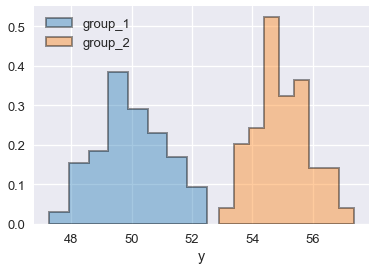

In [6]:
for cat in data.x.cat.categories:
    sns.distplot(data[data.x==cat].y, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled', 'edgecolor':'k', 'lw':2})

plt.legend();

## Bayesian modelling

In [7]:
BURNIN=1000
TUNE=1000
SAMPLES=1000

In [8]:
with pm.Model() as model:
    
    # Prior on 'mu'
    mu = pm.Normal('mu', mu=data.y.mean(), sd=50, shape=2)
    
    # Prior on 'sd'
    sd = pm.HalfNormal('sd', sd=50, shape=2)
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu[data.x.cat.codes.values], sd=sd[data.x.cat.codes.values], observed=data.y)
    
    delta_mu = pm.Deterministic('delta_mu', mu[1]-mu[0])
    delta_sd = pm.Deterministic('delta_sd', sd[1]-sd[0])
    
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, chains=4, cores=4, random_seed=SEED)

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains: 100%|████████████| 12000/12000 [00:11<00:00, 1052.95draws/s]


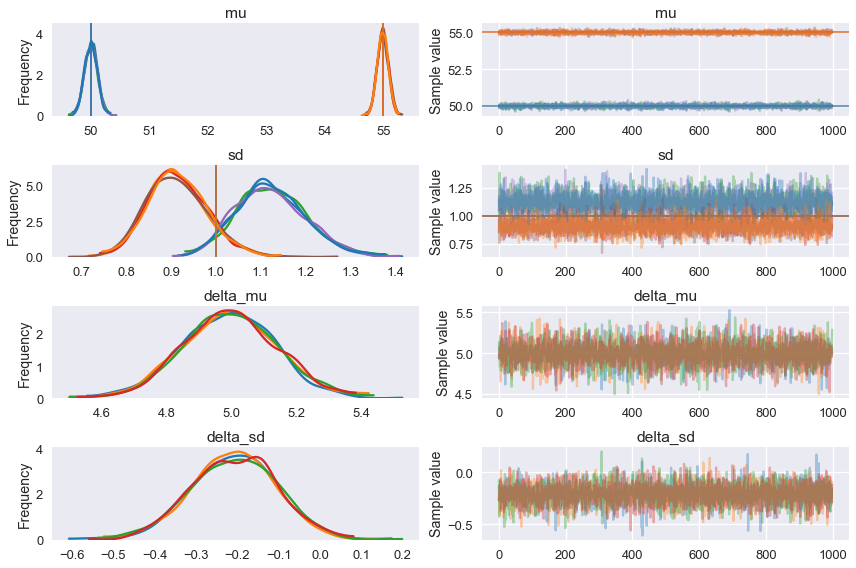

In [9]:
pm.traceplot(trace, lines={'mu':mu_real, 'sd':sd_real});

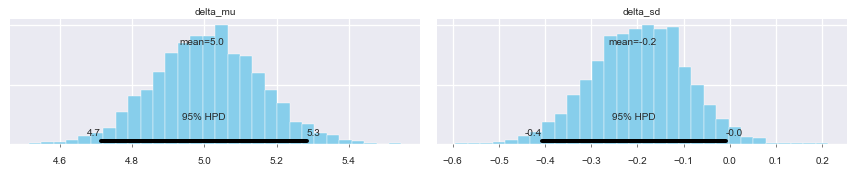

In [10]:
pm.plot_posterior(trace, varnames=['delta_mu', 'delta_sd'], round_to=1);

In [11]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,50.00,0.11,0.0,49.77,50.21,5823.69,1.0
mu__1,54.99,0.09,0.0,54.82,55.19,5806.74,1.0
sd__0,1.12,0.08,0.0,0.98,1.29,5894.19,1.0
sd__1,0.91,0.07,0.0,0.79,1.05,6344.73,1.0
delta_mu,4.99,0.15,0.0,4.71,5.28,5318.28,1.0
delta_sd,-0.21,0.10,0.0,-0.41,-0.01,6342.99,1.0


## Posterior predictive check

In [12]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,mu__0,mu__1,sd__0,sd__1,delta_mu,delta_sd
0,49.876947,54.822704,1.173057,0.897774,4.945757,-0.275283
1,50.091773,55.167919,1.046830,0.919088,5.076146,-0.127742
2,49.854512,54.785822,1.137307,0.983809,4.931310,-0.153498
3,49.904576,55.050668,1.139424,0.885015,5.146093,-0.254409
4,49.855437,55.069057,1.103018,0.870805,5.213620,-0.232212


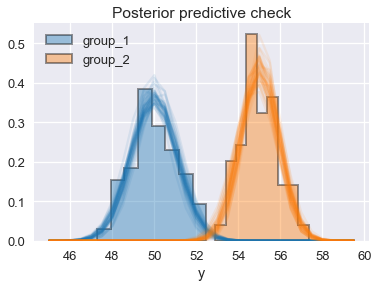

In [13]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(45, 60, 0.5)

for i, group in enumerate(data.x.cat.categories): 
    sns.distplot(data[data.x==group].y, kde=False, norm_hist=True, label=group, ax=ax, hist_kws={'histtype':'stepfilled', 'edgecolor':'k', 'lw':2})

    for mu, sd in zip(trace_df[f'mu__{i}'][::THIN], trace_df[f'sd__{i}'][::THIN]):
        ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[i])

plt.title('Posterior predictive check')
plt.legend();